In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from collections import OrderedDict
from manifold_helper import ManifoldHelper


rng = np.random.default_rng(seed=42)

def plot_images(data, n_img_per_row=10, cmap='gray'):
    shape = int(np.sqrt(len(data[0])))
    # plot iage of the digits
    img = np.zeros( (shape * n_img_per_row, shape * n_img_per_row) )
    for i in range( n_img_per_row ):
        ix = shape * i
        for j in range( n_img_per_row ):
            iy = shape * j
            img[ix:ix + shape, iy:iy + shape] = data[i * n_img_per_row + j].reshape( (shape, shape) )

    plt.figure(figsize=(15, 15))
    plt.imshow( img, cmap=cmap )
    plt.xticks( [] )
    plt.yticks( [] )
    plt.show()

In [2]:
n_class = 10 # n primeiros digitos
class_percent = 0.2 # porcentagem dos dados de cada classa que serão usados
rescale_factor = 1.0
is_invert = False
neighbors = [5, 10, 25, 50, 75, 100, 150, 200]
dimensions = [2, 5, 10, 50, 100, 150, 200]
methods = ['ISOMAP', 'LLE', 'SE']

# Carregando os dados

In [3]:
datasetOriginal = pd.read_csv("data/mnist_train.csv")
df = datasetOriginal.copy()
df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# separar os rotulos dos dados
label, x = df.iloc[:, :1], df.iloc[:, 1:]
label = label.to_numpy().transpose()[0]
x = x.to_numpy()
label, x

(array([5, 0, 4, ..., 5, 6, 8], dtype=int64),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64))

In [5]:
# sort de acordo com os labels
idx = np.argsort(label)
label = label[idx]
x = x[idx]
label, x

(array([0, 0, 0, ..., 9, 9, 9], dtype=int64),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64))

In [6]:
unique, counts = np.unique(label, return_counts=True)
num_data = dict(zip(unique, counts))
num_data

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

## Selecionando dados para analise

In [7]:
# selecionando apenas parte dos dados
x_cut = np.empty((0, 784))
label_cut = np.empty((1, 0), dtype=np.uint8)
for i in range(n_class):
    if i > 0:
        start = sum([num_data[j] for j in range(i)])
        end = int(num_data[i] * class_percent) + start
    else:
        start = 0
        end = int(num_data[i] * class_percent)
    label_cut = np.append(label_cut, label[start : end])
    x_cut = np.vstack((x_cut, x[start : end, :]))

unique, counts = np.unique(label_cut, return_counts=True)
num_data_cut = dict(zip(unique, counts))
num_data_cut

{0: 1184,
 1: 1348,
 2: 1191,
 3: 1226,
 4: 1168,
 5: 1084,
 6: 1183,
 7: 1253,
 8: 1170,
 9: 1189}

In [8]:
idx = np.random.RandomState(seed=42).permutation(len(x_cut))
x_cut = x_cut[idx, :]
label_cut = label_cut[idx]

In [9]:
label_colors = [list( mcolors.TABLEAU_COLORS )[i] for i in range( 10 )]
colors = [label_colors[v] for v in label_cut]

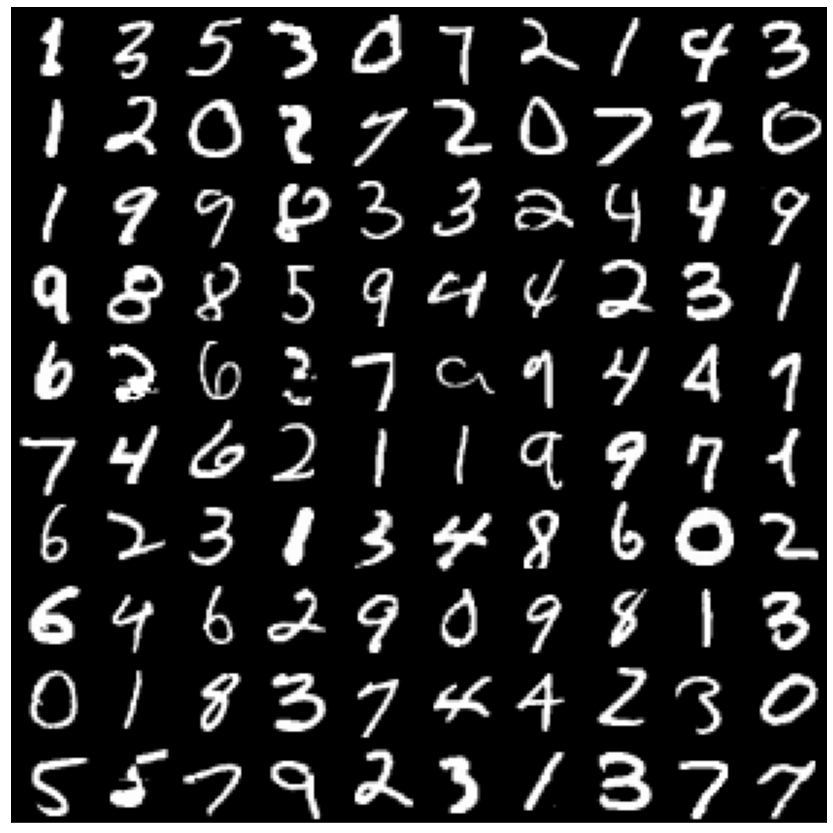

In [10]:
plot_images(x_cut)

# preprocessing

# ARI

Gerando os métodos para cada valor de vizinhos no intervalo

In [11]:
manifold = ManifoldHelper(neighbors, dimensions, methods)

Using alternative LTSA.
Using sklearn manifold methods.


In [12]:
ari_results = manifold.evaluate_all(x_cut, label_cut, n_components=n_class)


2_dimension:
   5_neighbors: 0.27(69.5s)  0.57(13.0s)  0.33(7.9s) 
   10_neighbors: 0.24(82.2s)  0.35(32.5s)  0.32(13.6s) 
   25_neighbors: 0.22(114.4s)  0.11(62.8s)  0.19(27.3s) 
   50_neighbors: 0.23(166.3s)  0.04(98.1s)  0.05(46.5s) 
   75_neighbors: 0.23(212.7s)  0.04(111.4s)  0.09(74.3s) 
   100_neighbors: 0.22(247.5s)  0.03(105.8s)  0.00(73.8s) 
   150_neighbors: 0.22(309.8s)  0.07(92.5s)  0.00(83.1s) 
   200_neighbors: 0.22(385.7s)  0.09(81.9s)  0.00(97.2s) 
5_dimension:
   5_neighbors: 0.55(67.2s)  0.52(12.1s)  0.51(7.2s) 
   10_neighbors: 0.53(79.0s)  0.49(30.4s)  0.48(12.1s) 
   25_neighbors: 0.40(108.4s)  0.33(57.5s)  0.38(25.6s) 
   50_neighbors: 0.47(153.3s)  0.18(88.6s)  0.17(42.8s) 
   75_neighbors: 0.39(195.4s)  0.12(95.9s)  0.15(66.1s) 
   100_neighbors: 0.37(236.2s)  0.14(99.2s)  0.13(70.0s) 
   150_neighbors: 0.38(312.1s)  0.16(92.7s)  0.01(84.3s) 
   200_neighbors: 0.37(387.9s)  0.17(82.8s)  0.00(97.7s) 
10_dimension:
   5_neighbors: 0.64(162.8s)  0.67(101.6s)  0.6

In [13]:
manifold.saveARI(ari_results, add='id_16')

[[0.2666276  0.2392159  0.22109274 0.23020161 0.22691314 0.2220965
  0.22343083 0.22222354]
 [0.54885042 0.53285221 0.39871812 0.47223655 0.39125462 0.3716642
  0.37530691 0.36898704]
 [0.63929963 0.57881728 0.63800772 0.56334397 0.50778678 0.52893429
  0.49789749 0.45988042]
 [0.62363547 0.64074423 0.58062807 0.61791136 0.6178297  0.52798657
  0.56348708 0.46138036]
 [0.66761914 0.65008825 0.60525952 0.56515783 0.53572024 0.49608895
  0.50222305 0.58244911]
 [0.59581027 0.6508656  0.54732922 0.5467702  0.52812661 0.55507332
  0.53350541 0.55552999]
 [0.6680093  0.64168807 0.56817889 0.56706836 0.54424752 0.5196732
  0.51524236 0.50609335]]
[[0.56816448 0.35175612 0.11028148 0.03971885 0.03686512 0.03109242
  0.07166089 0.0931234 ]
 [0.52255822 0.4933439  0.33472396 0.17835013 0.12202713 0.13608608
  0.16156549 0.16691651]
 [0.6719712  0.53937597 0.35059021 0.20510731 0.20544871 0.21013907
  0.18871592 0.19274074]
 [0.56847655 0.57856024 0.49538075 0.36464616 0.45432572 0.49779167
  0.

In [14]:
manifold.evaluate_gmm_ari(x_cut, label_cut, n_class)

0.2027853149818555